## Modul Preprocessing dan Feature Engineering Data Finansia

- Preprocessing: Membersihkan data (misal, volume '1.2K' menjadi 1200) dan menangani missing values.

- Feature Engineering: Menghitung puluhan indikator teknikal, pola candlestick, dan pola trigram.

- Finalisasi: Membuat variabel target y (prediksi naik/turun) dan menghapus kolom-kolom mentah.

In [ ]:
import pandas as pd
import ta
import numpy as np
import warnings

def parse_volume(value):
    """
    Mengubah kolom Vol. seperti '1.2K', '3M', '1,234' menjadi angka numerik.
    """
    if isinstance(value, str):
        # 1. Bersihkan spasi di awal/akhir
        value = value.strip()
        
        # 2. HAPUS pemisah ribuan (koma)
        #    Contoh: '1,234.5K' -> '1234.5K'
        #    Contoh: '1,234' -> '1234'
        value = value.replace(',', '') 
        
        # 3. Proses K, M, B
        if value.endswith('K'):
            # float('1.2') * 1000
            return float(value[:-1]) * 1_000
        elif value.endswith('M'):
            # float('3.5') * 1000000
            return float(value[:-1]) * 1_000_000
        elif value.endswith('B'):
            return float(value[:-1]) * 1_000_000_000
        elif value == '-': # Menangani jika ada data volume '-'
            return np.nan
        else:
            # Ini untuk menangani angka biasa yang terbaca sbg string (misal '1234')
            try:
                return float(value)
            except ValueError:
                return np.nan
                
    # Kembalikan nilai jika inputnya sudah numerik (bukan string)
    return value

def DEMA(series, period=14):
    """ Menghitung Double Exponential Moving Average (DEMA) """
    ema = series.ewm(span=period, adjust=False).mean()
    dema = 2 * ema - ema.ewm(span=period, adjust=False).mean()
    return dema

def kategori_candlestick(x):
    """ Fungsi helper untuk kategori candlestick pattern """
    if x < 0.1:
        return "Sangat Rendah"
    elif x < 0.3:
        return "Rendah"
    elif x < 0.6:
        return "Sedang"
    else:
        return "Tinggi"

# --- Fungsi Pemrosesan Utama ---

def process_dataframe(df_input):
    """
    Menerapkan semua langkah preprocessing dan feature engineering pada satu DataFrame.
    """
    # Salin agar tidak mengubah dataframe asli (best practice)
    df = df_input.copy()

    df.columns = df.columns.str.strip()

    # 1. Urutkan dari Date terlama ke terbaru
    try:
        df['Date'] = pd.to_datetime(df['Date'])
    except Exception as e:
        print(f"Peringatan: Gagal mengurai tanggal. Error: {e}")

    df = df.sort_values(by='Date', ascending=True).reset_index(drop=True)

    # 2. Menyesuaikan kolom Volume
    df['Vol.'] = df['Vol.'].apply(parse_volume)
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')

    # 3. Indikator Teknikal
    # Pastikan tidak ada error, gunakan warning filter jika perlu
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        warnings.simplefilter("ignore", category=FutureWarning)
        
        df['MA']    = ta.trend.SMAIndicator(df['Price'], window=5).sma_indicator()
        df['EMA']   = ta.trend.EMAIndicator(df['Price'], window=10).ema_indicator()
        df['DEMA']  = DEMA(df['Price'], period=5)
        df['KAMA']  = ta.momentum.KAMAIndicator(df['Price'], window=5).kama()
        df['SMA']   = ta.trend.SMAIndicator(df['Price'], window=10).sma_indicator()
        df['SAR']   = ta.trend.PSARIndicator(df['High'], df['Low'], df['Price']).psar()

        df['ADX']   = ta.trend.ADXIndicator(df['High'], df['Low'], df['Price'], window=10).adx()
        df['APO']   = df['Price'] - df['Price'].ewm(span=10, adjust=False).mean()
        df['BOP']   = (df['Price'] - df['Open']) / (df['High'] - df['Low']).replace(0, 1e-10)
        df['CCI']   = ta.trend.CCIIndicator(df['High'], df['Low'], df['Price'], window=10).cci()
        
        macd_custom = ta.trend.MACD(
            close=df['Price'], window_slow=10, window_fast=5, window_sign=9
        )
        df['MACD'] = macd_custom.macd()
        
        df['MFI']   = ta.volume.MFIIndicator(df['High'], df['Low'], df['Price'], df['Vol.'], window=10).money_flow_index()
        df['MOM'] = df['Price'] - df['Price'].shift(10)
        df['RSI']   = ta.momentum.RSIIndicator(df['Price'], window=10).rsi()

        df['AD']    = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Price'], df['Vol.']).acc_dist_index()
        df['ADOSC'] = ta.volume.ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Price'], df['Vol.'], window=10).chaikin_money_flow()
        df['OBV']   = ta.volume.OnBalanceVolumeIndicator(df['Price'], df['Vol.']).on_balance_volume()

        df['Prev_Close'] = df['Price'].shift(1)
        df['TRANGE'] = df[['High', 'Low', 'Prev_Close']].apply(
            lambda row: max(
                row['High'] - row['Low'],
                abs(row['High'] - row['Prev_Close']),
                abs(row['Low'] - row['Prev_Close'])
            ), axis=1
        )
        df['ATR'] = df['TRANGE'].ewm(span=10, adjust=False).mean()
        df['NATR'] = (df['ATR'] / df['Price']) * 100
        df.drop(columns=['Prev_Close'], inplace=True, errors='ignore')

    # 4. Candlestick Pattern
    df['Body'] = (df['Price'] - df['Open']).abs()
    df['Range'] = df['High'] - df['Low']
    df['Upper_Shadow'] = df['High'] - df[['Price','Open']].max(axis=1)
    df['Lower_Shadow'] = df[['Price','Open']].min(axis=1) - df['Low']

    df['P_Body'] = (df['Body'] / df['Range'].replace(0, np.nan)).fillna(0)
    df['P_Upper'] = (df['Upper_Shadow'] / df['Range'].replace(0, np.nan)).fillna(0)
    df['P_Lower'] = (df['Lower_Shadow'] / df['Range'].replace(0, np.nan)).fillna(0)

    df['K_Body'] = df['P_Body'].apply(kategori_candlestick)
    df['K_Upper'] = df['P_Upper'].apply(kategori_candlestick)
    df['K_Lower'] = df['P_Lower'].apply(kategori_candlestick)

    conditions_candle = [
        (df['K_Body'].isin(['Sedang', 'Tinggi'])) & (df['K_Upper'].isin(['Sedang', 'Tinggi'])) & (df['K_Lower'].isin(['Sedang', 'Tinggi'])) & (df['Price'] < df['Open']),
        (df['K_Body'].isin(['Sedang', 'Tinggi'])) & (df['K_Upper'].isin(['Sedang', 'Tinggi'])) & (df['K_Lower'].isin(['Sedang', 'Tinggi'])) & (df['Price'] > df['Open']),
        (df['K_Body'].isin(['Sedang', 'Tinggi'])) & (df['K_Upper'].isin(['Sedang', 'Tinggi'])) & (df['K_Lower'].isin(['Sangat Rendah', 'Rendah'])) & (df['Price'] < df['Open']),
        (df['K_Body'].isin(['Sedang', 'Tinggi'])) & (df['K_Upper'].isin(['Sedang', 'Tinggi'])) & (df['K_Lower'].isin(['Sangat Rendah', 'Rendah'])) & (df['Price'] > df['Open']),
        (df['K_Body'].isin(['Sedang', 'Tinggi'])) & (df['K_Upper'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Lower'].isin(['Sedang', 'Tinggi'])) & (df['Price'] < df['Open']),
        (df['K_Body'].isin(['Sedang', 'Tinggi'])) & (df['K_Upper'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Lower'].isin(['Sedang', 'Tinggi'])) & (df['Price'] > df['Open']),
        (df['K_Body'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Upper'].isin(['Sedang', 'Tinggi'])) & (df['K_Lower'].isin(['Sedang', 'Tinggi'])),
        (df['K_Body'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Upper'].isin(['Sedang', 'Tinggi'])) & (df['K_Lower'].isin(['Sangat Rendah', 'Rendah'])),
        (df['K_Body'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Upper'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Lower'].isin(['Sedang', 'Tinggi'])),
        (df['K_Body'].isin(['Sedang', 'Tinggi'])) & (df['K_Upper'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Lower'].isin(['Sangat Rendah', 'Rendah'])) & (df['Price'] < df['Open']),
        (df['K_Body'].isin(['Sedang', 'Tinggi'])) & (df['K_Upper'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Lower'].isin(['Sangat Rendah', 'Rendah'])) & (df['Price'] > df['Open']),
        (df['K_Body'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Upper'] == 'Sangat Rendah') & (df['K_Lower'] == 'Sangat Rendah') & (df['Price'] <= df['Open']),
        (df['K_Body'].isin(['Sangat Rendah', 'Rendah'])) & (df['K_Upper'] == 'Sangat Rendah') & (df['K_Lower'] == 'Sangat Rendah') & (df['Price'] >= df['Open'])
    ]
    choices_candle = [
        'Spinning Top Bearish', 'Spinning Top Bullish', 'Shooting Star', 'Inverted Hammer',
        'Hanging Man', 'Hammer', 'Doji', 'Gravestone Doji', 'Dragonfly Doji',
        'Marubozu Bearish', 'Marubozu Bullish', 'Bearish Full Marubozu', 'Bullish Full Marubozu'
    ]
    df['CandlePattern'] = np.select(conditions_candle, choices_candle, default='Uncategorized')

    # 5. Eight-Trigram
    conditions_trigram = [
        (df['Price'] >= df['Price'].shift(1)) & (df['High'] >= df['High'].shift(1)) & (df['Low'] >= df['Low'].shift(1)),
        (df['Price'] <= df['Price'].shift(1)) & (df['High'] <= df['High'].shift(1)) & (df['Low'] <= df['Low'].shift(1)),
        (df['Price'] >= df['Price'].shift(1)) & (df['High'] >= df['High'].shift(1)) & (df['Low'] <= df['Low'].shift(1)),
        (df['Price'] <= df['Price'].shift(1)) & (df['High'] >= df['High'].shift(1)) & (df['Low'] <= df['Low'].shift(1)),
        (df['Price'] >= df['Price'].shift(1)) & (df['High'] <= df['High'].shift(1)) & (df['Low'] >= df['Low'].shift(1)),
        (df['Price'] <= df['Price'].shift(1)) & (df['High'] <= df['High'].shift(1)) & (df['Low'] >= df['Low'].shift(1)),
        (df['Price'] <= df['Price'].shift(1)) & (df['High'] >= df['High'].shift(1)) & (df['Low'] >= df['Low'].shift(1)),
        (df['Price'] >= df['Price'].shift(1)) & (df['High'] <= df['High'].shift(1)) & (df['Low'] <= df['Low'].shift(1))
    ]
    values_trigram = [
        "BullishHigh", "BearLow", "BullishHorn", "BearHorn",
        "BullishHarami", "BearHarami", "BearHigh", "BullishLow"
    ]
    df['Pattern'] = np.select(conditions_trigram, values_trigram, default="Uncategorized")
    df['Pattern'] = df['Pattern'].fillna("Uncategorized")

    # 6. Variabel Y
    df['y'] = (df['Price'].shift(-1) > df['Price']).astype(int)
    df = df.iloc[:-1].reset_index(drop=True) # Hapus baris terakhir (NaN y)

    # 7. Hapus Kolom yang Tidak Dibutuhkan
    cols_to_drop = [
        "Date", "Price", "Open", "High", "Low", "Vol.","Change %",
        "Body", "Range", "Upper_Shadow", "Lower_Shadow", "P_Body", 
        "P_Upper", "P_Lower", "K_Body", "K_Upper", "K_Lower"
    ]
    # Gunakan errors='ignore' untuk menghindari error jika kolom sudah terhapus
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # 8. Hapus Baris yang Mengandung Missing Value
    df = df.dropna()
    
    return df

## Modul Pemuatan dan Penggabungan Data (Data Loader & Combiner)

Skrip ini adalah eksekutor. Tugasnya adalah memuat setiap file data mentah satu per satu, menjalankan seluruh fungsi preprocessing dan feature engineering (process_dataframe), lalu menggabungkan semua hasilnya menjadi satu dataset akhir (combined_data.csv) yang siap digunakan untuk analisis atau pelatihan model.

In [ ]:
# GANTI INI dengan 5 nama file Excel Anda
file_list = [
    'C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Aneka Tambang Persero Stock Price History.csv', 
    'C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Bumi Resources Min Stock Price History.csv', 
    'C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Medco Energi Stock Price History.csv', 
    'C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/J Resources Stock Price History.csv', 
    'C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Merdeka Copper Gold TBK PT Stock Price History.csv',
    'C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/data emas/United Tractors Stock Price History.csv'
]

processed_dfs = [] # List untuk menampung DataFrame yang sudah diproses

print("Memulai pemrosesan file...")

for file_name in file_list:
    try:
        print(f"Memuat dan memproses {file_name}...")
        
        # Muat file Excel
        df_raw = pd.read_csv(file_name, thousands=',', decimal='.')
        # Lakukan semua langkah pemrosesan
        df_processed = process_dataframe(df_raw)
        # Tambahkan ke list
        processed_dfs.append(df_processed)
        
        print(f"Selesai memproses {file_name}. Ditemukan {len(df_processed)} baris data valid.")
        
    except FileNotFoundError:
        print(f"ERROR: File {file_name} tidak ditemukan. Dilewati.")
    except Exception as e:
        print(f"ERROR: Terjadi masalah saat memproses {file_name}: {e}. Dilewati.")

# Gabungkan semua DataFrame yang telah diproses
if processed_dfs:
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    
    print("\n--- Pemrosesan Selesai ---")
    print("Data dari semua file berhasil digabungkan.")
    print(combined_df.info())
    
    # # Simpan ke CSV untuk langkah selanjutnya
    # combined_df.to_csv('combined_data.csv', index=False)
    # print("\nData gabungan telah disimpan ke 'combined_data.csv'")
else:
    print("\nTidak ada data yang berhasil diproses. Pastikan nama file sudah benar.")

Memulai pemrosesan file...
Memuat dan memproses C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Aneka Tambang Persero Stock Price History.csv...
Selesai memproses C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Aneka Tambang Persero Stock Price History.csv. Ditemukan 3290 baris data valid.
Memuat dan memproses C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Bumi Resources Min Stock Price History.csv...
Selesai memproses C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Bumi Resources Min Stock Price History.csv. Ditemukan 2904 baris data valid.
Memuat dan memproses C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Medco Energi Stock Price History.csv...
Selesai memproses C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/Medco Energi Stock Price History.csv. Ditemukan 3277 baris data valid.
Memuat dan memproses C:/Users/danu7/Downloads/Klasifikasi Emas/data emas/J Resources Stock Price History.csv...
Selesai memproses C:/Users/danu7/Downloads/Klasifikasi Emas/data emas

## Validasi Data dan Analisis Fitur

In [57]:
display(combined_df.head())

pola_y_counts = combined_df.groupby(['CandlePattern', 'y']).size().unstack(fill_value=0)
print("Jumlah dari 'CandlePattern' untuk setaiap nilai 'Y':")
display(pola_y_counts)

,MA,EMA,DEMA,KAMA,SMA,SAR,ADX,APO,BOP,CCI,...,RSI,AD,ADOSC,OBV,TRANGE,ATR,NATR,CandlePattern,Pattern,y
0,1856.0,1869.134389,1827.084568,-2.850288e+113,1871.0,1921.607196,0.0,-59.134389,-0.600000,-169.934641,...,21.118831,-5.047333e+06,-0.053377,-17470000.0,50.0,34.460214,1.903879,Marubozu Bearish,BearLow,0
1,1844.0,1858.382682,1812.840955,-2.838424e+113,1859.0,1914.310764,0.0,-48.382682,-0.500000,-152.777778,...,21.118831,-1.135733e+07,-0.114999,-11160000.0,20.0,31.831085,1.758623,Shooting Star,BullishHarami,0
2,1832.0,1849.585831,1806.194799,-2.826609e+113,1850.0,1907.452118,0.0,-39.585831,-0.500000,-114.683816,...,21.118831,-2.088733e+07,-0.208269,-1630000.0,20.0,29.679978,1.639778,Shooting Star,BullishHigh,1
3,1818.0,1844.206589,1809.219307,-2.814844e+113,1847.0,1901.004991,0.0,-24.206589,0.000000,-85.585586,...,27.532279,-1.865067e+07,-0.119798,5080000.0,30.0,29.738164,1.633965,Doji,BullishHorn,0
4,1810.0,1836.169027,1800.650277,-2.803128e+113,1840.0,1894.944692,0.0,-36.169027,-0.333333,-93.975904,...,23.319037,-2.269400e+07,-0.207582,-7050000.0,30.0,29.785771,1.654765,Spinning Top Bearish,BearLow,0


Jumlah dari 'CandlePattern' untuk setaiap nilai 'Y':


y,0,1
CandlePattern,,
Bearish Full Marubozu,336,75
Doji,975,595
Dragonfly Doji,798,456
Gravestone Doji,1085,740
Hammer,448,267
Hanging Man,877,469
Inverted Hammer,739,466
Marubozu Bearish,1709,1268
Marubozu Bullish,1038,682


## Strategi Penyeimbangan Data (Oversampling) Menggunakan SMOTENC

Kode ini mengatasi masalah imbalanced data (data tidak seimbang).

Solusinya:

- Target Kombinasi: Membuat target baru (target_combo) yang menggabungkan pola dan hasil (misal, 'Hammer_1').

- Encoding Fitur: Mengubah fitur 'Pattern' (kategorikal) di X menjadi angka agar bisa diproses.

- SMOTENC: Menjalankan SMOTENC, sebuah teknik oversampling canggih. Ini membuat data sintetis (data baru tiruan) untuk kelas-kelas target_combo yang jarang sampai jumlahnya seimbang.

- Rekonstruksi: Mengembalikan data ke format semula (decode 'Pattern' dan memecah 'target_combo') untuk analisis dan training.

In [58]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours
from IPython.display import display # Diperlukan untuk 'display()'

# --- 1. Persiapan Data (Target Kombinasi) ---
print("--- 1. Mempersiapkan Target Kombinasi ---")
combined_df['target_combo'] = combined_df['CandlePattern'].astype(str) + '_' + combined_df['y'].astype(str)

# Pisahkan X dan y
X = combined_df.drop(['CandlePattern', 'y', 'target_combo'], axis=1)
y = combined_df['target_combo']

# --- 2. Encoding Fitur Kategorikal di X ---
print("\n--- 2. Encoding Fitur Kategorikal (X) ---")
X_encoded = X.copy()
# Tentukan semua kolom string/kategorikal di X
categorical_cols = ['Pattern'] 
categorical_indices = [X_encoded.columns.get_loc(col) for col in categorical_cols]
print(f"Indeks kolom kategorikal di X: {categorical_indices}")

# === Buat dictionary untuk MENYIMPAN encoder ===
encoders = {}

print("Menerapkan LabelEncoder dan menyimpan encoders...")
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    # Simpan 'le' yang sudah dilatih ke dalam dictionary
    encoders[col] = le
print("Selesai menyimpan encoders.")

# --- 3. LANGKAH 1: Terapkan SMOTENC (Oversampling) ---
print("\n--- 3. Menerapkan SMOTENC (Oversampling) ---")
smote_nc = SMOTENC(categorical_features=categorical_indices, 
                     random_state=100, 
                     sampling_strategy='auto')

X_smote, y_smote = smote_nc.fit_resample(X_encoded, y)
print(f"Shape setelah SMOTENC: {X_smote.shape}")

# --- 4. Gabungkan Kembali (Reconstruction) ---

# --- Bagian 4a: Buat DataFrame final dari X_smote ---
final_df = pd.DataFrame(X_smote, columns=X_encoded.columns)

# --- Bagian 4b: Kembalikan fitur kategorikal (Pattern) ke string ---
print("\n--- 4b. Mengembalikan kolom fitur ke string ---")

# === PERBAIKAN 2: Gunakan dictionary 'encoders' untuk inverse_transform ===
for col, le in encoders.items():
    try:
        # Ambil 'le' yang benar dari dictionary
        final_df[col] = le.inverse_transform(final_df[col])
        print(f"Berhasil mengembalikan '{col}' ke string.")
    except Exception as e:
        print(f"Error saat inverse_transform '{col}': {e}")

# --- Bagian 4c: "Bongkar" y_smote (target 'Doji_0') ---
print("\n--- 4c. Membongkar target_combo y_smote ---")
y_series = pd.Series(y_smote, name="target_combo")
split_data = y_series.str.split('_', expand=True)
split_data.columns = ['CandlePattern', 'y']
split_data['y'] = split_data['y'].astype(int)

# --- Bagian 4d: Gabungkan semuanya ---
resampled_df = pd.concat([final_df, split_data], axis=1)

# --- 5. Tampilkan Hasil ---
print("\n--- 6. DataFrame Final Hasil Resampling ---")
display(resampled_df.head())

print("\n--- Jumlah data Baru (Seimbang) ---")
display(resampled_df.groupby(['CandlePattern', 'y']).size().unstack(fill_value=0))

--- 1. Mempersiapkan Target Kombinasi ---

--- 2. Encoding Fitur Kategorikal (X) ---
Indeks kolom kategorikal di X: [20]
Menerapkan LabelEncoder dan menyimpan encoders...
Selesai menyimpan encoders.

--- 3. Menerapkan SMOTENC (Oversampling) ---
Shape setelah SMOTENC: (41016, 21)

--- 4b. Mengembalikan kolom fitur ke string ---
Berhasil mengembalikan 'Pattern' ke string.

--- 4c. Membongkar target_combo y_smote ---

--- 6. DataFrame Final Hasil Resampling ---


,MA,EMA,DEMA,KAMA,SMA,SAR,ADX,APO,BOP,CCI,...,RSI,AD,ADOSC,OBV,TRANGE,ATR,NATR,Pattern,CandlePattern,y
0,1856.0,1869.134389,1827.084568,-2.850288e+113,1871.0,1921.607196,0.0,-59.134389,-0.600000,-169.934641,...,21.118831,-5.047333e+06,-0.053377,-17470000.0,50.0,34.460214,1.903879,BearLow,Marubozu Bearish,0
1,1844.0,1858.382682,1812.840955,-2.838424e+113,1859.0,1914.310764,0.0,-48.382682,-0.500000,-152.777778,...,21.118831,-1.135733e+07,-0.114999,-11160000.0,20.0,31.831085,1.758623,BullishHarami,Shooting Star,0
2,1832.0,1849.585831,1806.194799,-2.826609e+113,1850.0,1907.452118,0.0,-39.585831,-0.500000,-114.683816,...,21.118831,-2.088733e+07,-0.208269,-1630000.0,20.0,29.679978,1.639778,BullishHigh,Shooting Star,1
3,1818.0,1844.206589,1809.219307,-2.814844e+113,1847.0,1901.004991,0.0,-24.206589,0.000000,-85.585586,...,27.532279,-1.865067e+07,-0.119798,5080000.0,30.0,29.738164,1.633965,BullishHorn,Doji,0
4,1810.0,1836.169027,1800.650277,-2.803128e+113,1840.0,1894.944692,0.0,-36.169027,-0.333333,-93.975904,...,23.319037,-2.269400e+07,-0.207582,-7050000.0,30.0,29.785771,1.654765,BearLow,Spinning Top Bearish,0



--- Jumlah data Baru (Seimbang) ---


y,0,1
CandlePattern,,
Bearish Full Marubozu,1709,1709
Doji,1709,1709
Dragonfly Doji,1709,1709
Gravestone Doji,1709,1709
Hammer,1709,1709
Hanging Man,1709,1709
Inverted Hammer,1709,1709
Marubozu Bearish,1709,1709
Marubozu Bullish,1709,1709


## Pelatihan, Tuning, dan Penyimpanan Model Berbasis Pola

Ini adalah skrip utama untuk pelatihan model. Alih-alih melatih satu model untuk semua data, skrip ini menerapkan strategi "satu model per pola candlestick".

Untuk setiap pola (misal, 'Hammer', 'Doji', dll.):

1. Melatih 2 Tipe Model: Menjalankan GridSearchCV untuk Logistic Regression dan Random Forest secara terpisah.

2. Menggunakan Pipeline: Mengotomatiskan proses preprocessing (StandardScaler untuk numerik dan OneHotEncoder untuk kategorikal) di dalam GridSearchCV.

3. Memilih Juara: Membandingkan F1-Score dari kedua model tersebut.

4. Menyimpan Model Terbaik: Menyimpan hanya model juara (misal, RandomForest untuk 'Hammer', LogisticRegression untuk 'Doji') sebagai file .pkl di folder saved_models untuk digunakan nanti saat prediksi.

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# --- Menggunakan Pipeline standar ---
from sklearn.pipeline import Pipeline
import warnings

# Mengabaikan warning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- 1. Muat Data Gabungan ---
try:
    combined_df = resampled_df.copy()
    print(f"Data berhasil diambil dari 'resampled_df' yang ada di memori. Shape: {combined_df.shape}")
except NameError:
    print("Error: Variabel 'resampled_df' tidak ditemukan di memori.")
print("--------------------------------------------------")

# --- 2. Tentukan Kolom Fitur ---
# 'Pattern' adalah kategorikal, sisanya numerik, (Kita tidak menyertakan 'y' atau 'CandlePattern')
try:
    numerical_features = combined_df.drop(['y', 'CandlePattern', 'Pattern'], axis=1, errors='ignore').columns.tolist()
    categorical_features = ['Pattern']
    print(f"Total Fitur Numerik: {len(numerical_features)}")
    print(f"Fitur Kategorikal: {categorical_features}")
except KeyError:
    print("Error: Kolom 'y', 'CandlePattern', atau 'Pattern' tidak ditemukan. Cek data Anda.")
    exit()


# --- 3. Buat Objek Preprocessor (Bagian dari Pipeline) ---
# Ini akan diterapkan SECARA OTOMATIS oleh Pipeline di dalam GridSearchCV
print("Mendefinisikan Preprocessor Pipeline...")

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("Preprocessor (Scaler + OneHotEncoder) siap.")
print("--------------------------------------------------")

# --- 4. Tentukan Parameter Grids ---
lr_param_grid = {
    'model__C': np.logspace(-2, 3, 10) # 'model__' adalah awalan untuk langkah 'model'
}
rf_param_grid_simple = {
    'model__n_estimators': [10, 50, 95],
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_leaf': [2, 6, 50],
    'model__max_depth': [1, 5, 9],
    'model__class_weight': ['balanced'] 
}

# --- 5. Loop Pelatihan Model per Pola (Menggunakan Pipeline) ---
print("Memulai Loop Pelatihan Model per Pola...")

lr_results = []
rf_results = []
unique_polas = combined_df['CandlePattern'].unique()

for pola in unique_polas:
    print(f"\n--- 🏋️ Melatih Model untuk Pola: {pola} ---")
    
    # a. Filter data untuk pola ini
    subset_df = combined_df[combined_df['CandlePattern'] == pola].copy()
    
    # b. Siapkan X dan y untuk subset ini
    X_pola = subset_df.drop(['y', 'CandlePattern'], axis=1, errors='ignore')
    y_pola = subset_df['y']
    
    # c. Cek data
    if len(y_pola) < 40 or len(y_pola.value_counts()) < 2:
        print(f"⚠️ Melewatkan {pola}: Data tidak cukup ({len(y_pola)} baris) atau hanya memiliki satu kelas.")
        continue
        
    # d. Split data (WAJIB dilakukan SEBELUM preprocessing)
    X_train, X_test, y_train, y_test = train_test_split(X_pola, y_pola, test_size=0.2, random_state=42, stratify=y_pola)

    # === f. Pipeline & GridSearchCV untuk Logistic Regression ===
    print(f"  Menjalankan GridSearchCV Logistic Regression untuk {pola}...")
    
    # Inilah Scikit-Learn Pipeline untuk model LR:
    lr_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), # Langkah 1: Menerapkan StandardScaler & OneHotEncoder
        ('model', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)) # Langkah 2: Model
    ])
    
    lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=0)
    lr_grid_search.fit(X_train, y_train)
    
    y_pred_lr = lr_grid_search.predict(X_test)
    
    lr_results.append({
        'CandlePattern': pola, 'Model': 'Logistic Regression',
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'f1_score': f1_score(y_test, y_pred_lr, average='weighted', zero_division=0),
        'best_params': lr_grid_search.best_params_,
    })
    print(f"  LR Selesai. Akurasi Uji: {accuracy_score(y_test, y_pred_lr):.4f}")

    # === g. Pipeline & GridSearchCV untuk Random Forest ===
    print(f"  Menjalankan GridSearchCV Random Forest untuk {pola}...")
    
    # Inilah Scikit-Learn Pipeline untuk model RF:
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), # Langkah 1: Menerapkan StandardScaler & OneHotEncoder
        ('model', RandomForestClassifier(random_state=42)) # Langkah 2: Model
    ])
    
    rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid_simple, cv=10, scoring='accuracy', n_jobs=-1, verbose=0)
    rf_grid_search.fit(X_train, y_train)
    
    y_pred_rf = rf_grid_search.predict(X_test)
    
    rf_results.append({
        'CandlePattern': pola, 'Model': 'Random Forest',
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'f1_score': f1_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        'best_params': rf_grid_search.best_params_
    })
    print(f"  RF Selesai. Akurasi Uji: {accuracy_score(y_test, y_pred_rf):.4f}")

### ============================================================ ###
### Menyimpan model terbaik per pola ke file .pkl (pakai joblib) ###
### ============================================================ ###

import joblib
import os

all_results = pd.DataFrame(lr_results + rf_results)

# Tentukan folder penyimpanan model
os.makedirs("saved_models", exist_ok=True)

# Loop setiap pola unik
for pola in all_results['CandlePattern'].unique():
    subset = all_results[all_results['CandlePattern'] == pola]
    
    # Pilih model dengan F1-score terbaik (bisa diganti accuracy)
    best_row = subset.loc[subset['f1_score'].idxmax()]

    # Simpan model sesuai jenisnya
    best_model_name = best_row['Model']
    print(f"\n🏆 Pola {pola}: Model terbaik adalah {best_model_name} (F1={best_row['f1_score']:.4f})")

    # Buat ulang pipeline dengan parameter terbaik dan latih ulang dengan semua data
    X_all = combined_df[combined_df['CandlePattern'] == pola].drop(['y', 'CandlePattern'], axis=1, errors='ignore')
    y_all = combined_df[combined_df['CandlePattern'] == pola]['y']

    if best_model_name == "Logistic Regression":
        best_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', LogisticRegression(
                solver='lbfgs', max_iter=1000, random_state=42,
                C=best_row['best_params']['model__C']
            ))
        ])
    else:
        best_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', RandomForestClassifier(
                random_state=42,
                n_estimators=best_row['best_params']['model__n_estimators'],
                criterion=best_row['best_params']['model__criterion'],
                min_samples_leaf=best_row['best_params']['model__min_samples_leaf'],
                max_depth=best_row['best_params']['model__max_depth'],
                class_weight='balanced'
            ))
        ])

    # Fit ulang dengan semua data pola ini
    best_pipeline.fit(X_all, y_all)

    # Simpan modelnya pakai joblib
    filename = f"saved_models/{pola}_{best_model_name.replace(' ', '_')}.pkl"
    joblib.dump(best_pipeline, filename)

Data berhasil diambil dari 'resampled_df' yang ada di memori. Shape: (41016, 23)
--------------------------------------------------
Total Fitur Numerik: 20
Fitur Kategorikal: ['Pattern']
Mendefinisikan Preprocessor Pipeline...
Preprocessor (Scaler + OneHotEncoder) siap.
--------------------------------------------------
Memulai Loop Pelatihan Model per Pola...

--- 🏋️ Melatih Model untuk Pola: Marubozu Bearish ---
  Menjalankan GridSearchCV Logistic Regression untuk Marubozu Bearish...
  LR Selesai. Akurasi Uji: 0.5731
  Menjalankan GridSearchCV Random Forest untuk Marubozu Bearish...
  RF Selesai. Akurasi Uji: 0.5556

--- 🏋️ Melatih Model untuk Pola: Shooting Star ---
  Menjalankan GridSearchCV Logistic Regression untuk Shooting Star...
  LR Selesai. Akurasi Uji: 0.5906
  Menjalankan GridSearchCV Random Forest untuk Shooting Star...
  RF Selesai. Akurasi Uji: 0.6784

--- 🏋️ Melatih Model untuk Pola: Doji ---
  Menjalankan GridSearchCV Logistic Regression untuk Doji...
  LR Selesai. Ak

## Evaluasi dan Visualisasi Performa Model

Ini adalah langkah akhir untuk pelaporan hasil.

Kode ini menggabungkan semua skor (akurasi dan F1-score) dari pelatihan Logistic Regression dan Random Forest ke dalam satu tabel.

Setelah itu, ia membuat sebuah bar plot untuk membandingkan secara visual model mana yang berkinerja terbaik (berdasarkan F1-score) untuk setiap CandlePattern yang berbeda.

Semua pelatihan selesai. Menggabungkan hasil...

--- === Hasil Akhir Gabungan === ---


,CandlePattern,Model,accuracy,f1_score,best_params
23,Bearish Full Marubozu,Random Forest,0.945906,0.945904,"{'model__class_weight': 'balanced', 'model__cr..."
11,Bearish Full Marubozu,Logistic Regression,0.795322,0.795315,{'model__C': 21.544346900318846}
14,Doji,Random Forest,0.707602,0.707352,"{'model__class_weight': 'balanced', 'model__cr..."
2,Doji,Logistic Regression,0.571637,0.571629,{'model__C': 1000.0}
22,Dragonfly Doji,Random Forest,0.736842,0.736840,"{'model__class_weight': 'balanced', 'model__cr..."
10,Dragonfly Doji,Logistic Regression,0.564327,0.564145,{'model__C': 0.01}
20,Gravestone Doji,Random Forest,0.643275,0.639278,"{'model__class_weight': 'balanced', 'model__cr..."
8,Gravestone Doji,Logistic Regression,0.526316,0.525000,{'model__C': 5.994842503189409}
18,Hammer,Random Forest,0.799708,0.798837,"{'model__class_weight': 'balanced', 'model__cr..."
6,Hammer,Logistic Regression,0.595029,0.594084,{'model__C': 5.994842503189409}



--- === Visualisasi Perbandingan F1_Score === ---


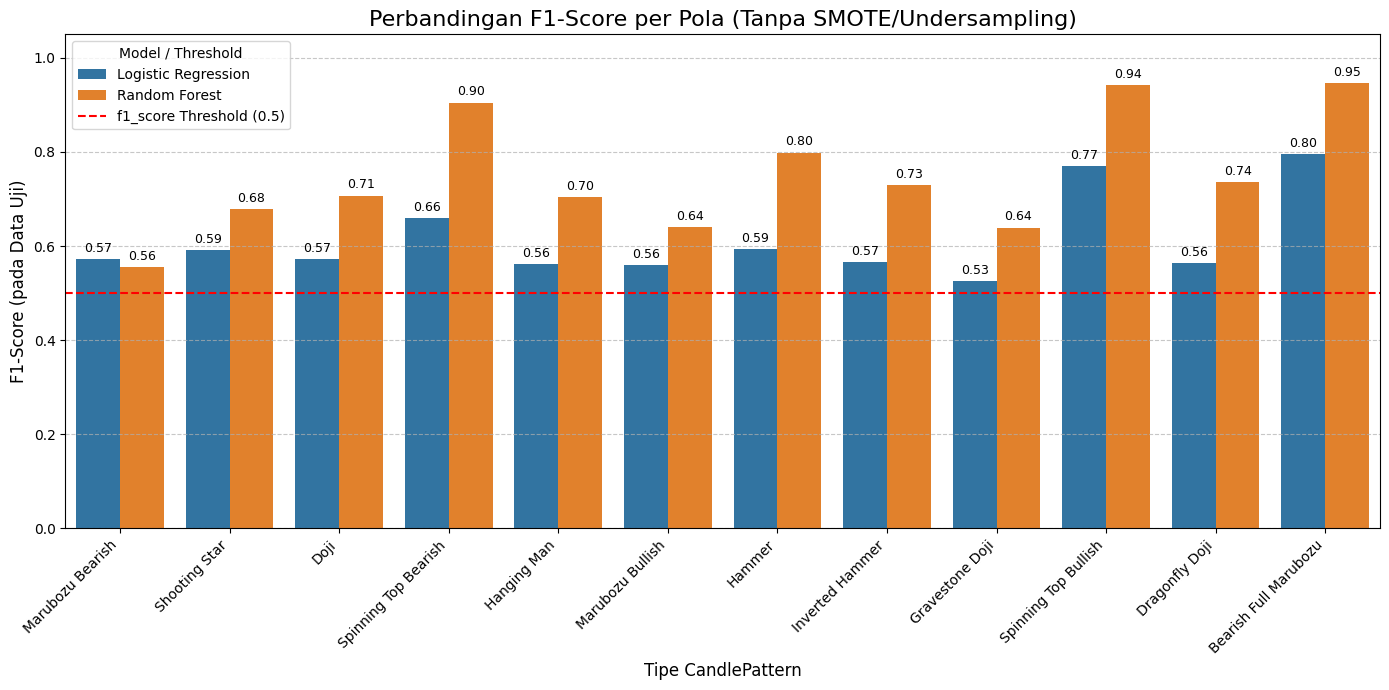

In [60]:
# --- Gabungkan Hasil dan Visualisasikan ---
print("Semua pelatihan selesai. Menggabungkan hasil...")

lr_df = pd.DataFrame(lr_results)
rf_df = pd.DataFrame(rf_results)
combined_results_df = pd.concat([lr_df, rf_df], ignore_index=True)

print("\n--- === Hasil Akhir Gabungan === ---")
display(combined_results_df.sort_values(by=['CandlePattern', 'f1_score'], ascending=[True, False]))

# --- Visualisasi ---
print("\n--- === Visualisasi Perbandingan F1_Score === ---")
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=combined_results_df, x='CandlePattern', y='f1_score', hue='Model')
plt.axhline(y=0.5, color='r', linestyle='--', label='f1_score Threshold (0.5)')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=9, padding=3)

plt.title('Perbandingan F1-Score per Pola (Tanpa SMOTE/Undersampling)', fontsize=16)
plt.xlabel('Tipe CandlePattern', fontsize=12)
plt.ylabel('F1-Score (pada Data Uji)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model / Threshold', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)
plt.tight_layout()

## Selesai